Based on https://github.com/ml4a/ml4a-guides/blob/master/notebooks/word2vec_tsne.ipynb

# Word2Vec and t-SNE

A question that might come up when working with text is: how do you turn text into numbers?

In the past, common techniques included methods like one-hot vectors, in which we'd have a different number associated with each word, and then turn "on" the value at that index in a vector (making it 1) and setting all the rest to zero.

For instance, if we have the sentence: "I like dogs", we'd have a 3-dimensional one-hot vector (3-dimensional because there are three words), so the word "I" might be `[1,0,0]`, the word "like" might be `[0,1,0]`, and "dogs" would be `[0,0,1]`.

One-hot vectors worked well enough for some tasks but it's not a particularly rich or meaningful representation of text. The indices of these words are arbitrary and don't describe any relationship between them.

[_Word embeddings_](http://arxiv.org/pdf/1301.3781.pdf) provide a meaningful representation of text. Word embeddings, called such because they involve embedding a word in some high-dimensional space, that is, they map a word to some vector, much like one-hot vectors. The difference is that word embeddings are learned for a particular task, so they end up being meaningful representations.

For example, the relationships between words are meaningful (image from the [TensorFlow documentation]((https://www.tensorflow.org/versions/r0.9/tutorials/word2vec/index.html)):

![Word embedding relationships](https://www.tensorflow.org/versions/r0.9/images/linear-relationships.png){:width="100%"}

A notable property that emerges is that vector arithmetic is also meaningful. Perhaps the most well-known example of this is:

$$
\text{king} - \text{man} + \text{woman} = \text{queen}
$$

([Chris Olah's piece on word embeddings](Deep Learning, NLP, and Representations) delves more into why this is.)

So the positioning of these words in this space actually tells us something about how these words are used.

This allows us to do things like find the most similar words by looking at the closest words. You can project the resulting embeddings down to 2D so that we can visualize them. We'll use t-SNE ("t-Distributed Stochastic Neighbor Embedding") for this, which is a dimensionality reduction method that works well for visualizing high-dimension data. We'll see that clusters of related words form in a way that a human would probably agree with. We couldn't do this with one-hot vectors - the distances between them are totally arbitrary and their proximity is essentially random.

As mentioned earlier, these word embeddings are trained to help with a particular task, which is learned through a neural network. Two tasks developed for training embeddings is _CBOW_ (continuous bag of words) and _skip-grams_; together these methods of learning word embeddings are called "Word2Vec".

For the CBOW task, we take the context words (the words around the target word) and give the target word. We want to predict whether or not the target word belongs to the context.

The skip-grams is basically the inverse: we take the target word (the "pivot"), then give the context. We want to predict whether or not the context belongs to the word.

They are quite similar but have different properties, e.g. CBOW works better on smaller datasets, where as skip-grams works better for larger ones. In any case, the idea with word embeddings is that they can be trained to help with any task.

We're going to be using the skip-gram task here.

## Corpus

We need a reasonably-sized text corpus to learn from. Here we'll use State of the Union addresses retrieved from [The American Presidency Project](http://www.presidency.ucsb.edu/sou.php). These addresses tend to use similar patterns so we should be able to learn some decent word embeddings. Since the skip-gram task looks at context, texts that use words in a consistent way (i.e. in consistent contexts) we'll be able to learn better.

[The corpus is available here](/guides/data/sotu.tar.gz). The texts were preprocessed a bit (mainly removing URL-encoded characters). The texts provided here are the processed versions (nb: this isn't the complete collection of texts but enough to work with here).

## Skip-grams

Before we go any further, let's get a bit more concrete about what the skip-gram task is.

Let's consider the sentence "I think cats are cool".

The skip-gram task is as follows:

- We take a word, e.g. `'cats'`, which we'll represent as $w_i$. We feed this as input into our neural network.
- We take the word's context, e.g. `['I', 'think', 'are', 'cool']`. We'll represent this as $\{w_{i-2}, w_{i-1}, w_{i+1}, w_{i+2}\}$ and we also feed this into our neural network.
- Then we just want our network to predict (i.e. classify) whether or not $\{w_{i-2}, w_{i-1}, w_{i+1}, w_{i+2}\}$ is the true context of $w_i$.

For this particular example we'd want the network to output 1 (i.e. yes, that is the true context).

If we set $w_i$ to 'frogs', then we'd want the network output 0. In our one sentence corpus, `['I', 'think', 'are', 'cool']` is not the true context for 'frogs'. Sorry frogs 🐸.

## Building the model

We'll use `keras` to build the neural network that we'll use to learn the embeddings.

First we'll import everything:

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Activation, Merge
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams, make_sampling_table

Using TensorFlow backend.


Then load in our data. We're actually going to define a generator to load our data in on-demand; this way we'll avoid having all our data sitting around in memory when we don't need it.

In [2]:
from glob import glob
text_files = glob('./data/sotu/*.txt')

def text_generator():
    for path in text_files:
        with open(path, 'r') as f:
            yield f.read()
            
len(text_files)
print(text_files[0:5])

['./data/sotu/Barack-Obama_2009.txt', './data/sotu/George-W.-Bush_2006.txt', './data/sotu/Dwight-D.-Eisenhower_1959.txt', './data/sotu/Barack-Obama_2013.txt', './data/sotu/Ronald-Reagan_1983.txt']


Before we go any further, we need to map the words in our corpus to numbers, so that we have a consistent way of referring to them. First we'll fit a tokenizer to the corpus:

In [3]:
# our corpus is small enough where we
# don't need to worry about this, but good practice
max_vocab_size = 50000

# `filters` specify what characters to get rid of
tokenizer = Tokenizer(num_words=max_vocab_size,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n\'`“”–')

# fit the tokenizer
tokenizer.fit_on_texts(text_generator())



In [4]:
# we also want to keep track of the actual vocab size
# we'll need this later
# note: we add one because `0` is a reserved index in keras' tokenizer
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

14967


Now the tokenizer knows what tokens (words) are in our corpus and has mapped them to numbers. The `keras` tokenizer also indexes them in order of frequency (most common first, i.e. index 1 is usually a word like "the"), which will come in handy later.

At this point, let's define the dimensions of our embeddings. It's up to you and your task to choose this number. Like many neural network hyperparameters, you may just need to play around with it.

In [5]:
embedding_dim = 256

Now let's define the model. When I described the skip-gram task, I mentioned two inputs: the target word (also called the "pivot") and the context. So we're going to build two separate models for each input and then merge them into one.

In [6]:
pivot_model = Sequential()
pivot_model.add(Embedding(vocab_size, embedding_dim, input_length=1))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embedding_dim, input_length=1))

# merge the pivot and context models
model = Sequential()
model.add(Merge([pivot_model, context_model], mode='dot', dot_axes=2))
model.add(Flatten())

# the task as we've framed it here is
# just binary classification,
# so we want the output to be in [0,1],
# and we can use binary crossentropy as our loss
model.add(Activation('sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [9]:
pivot_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 256)            3831552   
Total params: 3,831,552
Trainable params: 3,831,552
Non-trainable params: 0
_________________________________________________________________


In [10]:
context_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1, 256)            3831552   
Total params: 3,831,552
Trainable params: 3,831,552
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 1, 1)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 7,663,104
Trainable params: 7,663,104
Non-trainable params: 0
_________________________________________________________________


Finally, we can train the model.
This might take about 20 minutes...

In [16]:
n_epochs = 60

# used to sample words (indices)
#Generates a word rank-based probabilistic sampling table.
sampling_table = make_sampling_table(vocab_size)
print(len(sampling_table))
print(sampling_table)

14967
[ 0.00315225  0.00315225  0.00547597 ...,  1.          1.          1.        ]


In [9]:

for i in range(n_epochs):
    loss = 0
    for seq in tokenizer.texts_to_sequences_generator(text_generator()):
        # generate skip-gram training examples
        # - `couples` consists of the pivots (i.e. target words) and surrounding contexts
        # - `labels` represent if the context is true or not
        # - `window_size` determines how far to look between words
        # - `negative_samples` specifies the ratio of negative couples
        #    (i.e. couples where the context is false)
        #    to generate with respect to the positive couples;
        #    i.e. `negative_samples=4` means "generate 4 times as many negative samples"
        couples, labels = skipgrams(seq, vocab_size, window_size=5, negative_samples=4, sampling_table=sampling_table)
        if couples:
            pivot, context = zip(*couples)
            pivot = np.array(pivot, dtype='int32')
            context = np.array(context, dtype='int32')
            labels = np.array(labels, dtype='int32')
            loss += model.train_on_batch([pivot, context], labels)
    print('epoch %d, %0.02f'%(i, loss))

epoch 0, 57.93
epoch 1, 47.39
epoch 2, 28.03
epoch 3, 21.43
epoch 4, 19.45
epoch 5, 18.63
epoch 6, 18.25
epoch 7, 18.01
epoch 8, 17.92
epoch 9, 17.77
epoch 10, 17.69
epoch 11, 17.61
epoch 12, 17.50
epoch 13, 17.39
epoch 14, 17.34
epoch 15, 17.20
epoch 16, 17.10
epoch 17, 16.95
epoch 18, 16.82
epoch 19, 16.66
epoch 20, 16.53
epoch 21, 16.37
epoch 22, 16.15
epoch 23, 16.04
epoch 24, 15.85
epoch 25, 15.66
epoch 26, 15.47
epoch 27, 15.26
epoch 28, 15.01
epoch 29, 14.79
epoch 30, 14.60
epoch 31, 14.38
epoch 32, 14.08
epoch 33, 13.91
epoch 34, 13.65
epoch 35, 13.44
epoch 36, 13.20
epoch 37, 12.96
epoch 38, 12.74
epoch 39, 12.50
epoch 40, 12.26
epoch 41, 12.04
epoch 42, 11.84
epoch 43, 11.64
epoch 44, 11.47
epoch 45, 11.26
epoch 46, 11.07
epoch 47, 10.92
epoch 48, 10.72
epoch 49, 10.58
epoch 50, 10.42
epoch 51, 10.23
epoch 52, 10.13
epoch 53, 9.96
epoch 54, 9.84
epoch 55, 9.71
epoch 56, 9.57
epoch 57, 9.45
epoch 58, 9.35
epoch 59, 9.27


With any luck, the model should finish training without a hitch.

Now we can extract the embeddings, which are just the weights of the pivot embedding layer:

In [10]:
embeddings = model.get_weights()[0]

In [11]:
embeddings=embeddings[0]

In [12]:
embeddings.shape

(14967, 256)

We also want to set aside the tokenizer's word index for later use (so we can get indices for words) and also create a reverse word index (so we can get words from indices):

In [13]:
word_index = tokenizer.word_index
reverse_word_index = {v: k for k, v in word_index.items()}

That's it for learning the embeddings. Now we can try using them.

## Getting similar words

Each word embedding is just a mapping of a word to some point in space. So if we want to find words similar to some target word, we literally just need to look at the closest embeddings to that target word's embedding.

An example will make this clearer.

First, let's write a simple function to retrieve an embedding for a word:

In [14]:
def get_embedding(word):
    idx = word_index[word]
    # make it 2d
    return embeddings[idx][:,np.newaxis].T

Then we can define a function to get a most similar word for an input word:

In [15]:
from scipy.spatial.distance import cdist

ignore_n_most_common = 50

def get_closest(word):
    embedding = get_embedding(word)

    # get the distance from the embedding
    # to every other embedding
    distances = cdist(embedding, embeddings)[0]

    # pair each embedding index and its distance
    distances = list(enumerate(distances))

    # sort from closest to furthest
    distances = sorted(distances, key=lambda d: d[1])

    # skip the first one; it's the target word
    for idx, dist in distances[1:]:
        # ignore the n most common words;
        # they can get in the way.
        # because the tokenizer organized indices
        # from most common to least, we can just do this
        if idx > ignore_n_most_common:
            return reverse_word_index[idx]

Now let's give it a try (you may get different results):

In [16]:
word='freedom'
idx = word_index[word]
print(idx)


105


In [17]:
print(get_closest('freedom'))
print(get_closest('justice'))
print(get_closest('america'))
print(get_closest('citizens'))
print(get_closest('citizen'))

peace
reverted
nation
country
every


For the most part, we seem to be getting related words!

NB: Here we computed distances to _every_ other embedding, which is far from ideal when dealing with really large vocabularies. `Gensim`'s [`Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html) class implements a `most_similar` method that uses an approximate, but much faster, method for finding similar words. You can import the embeddings learned here into that class

#!pip install gensim

We are not going to use gensim


In [19]:
with open('./results/embeddings.dat', 'w') as f:
    f.write('{} {}'.format(vocab_size, embedding_dim))

    for word, idx in word_index.items():
        embedding = ' '.join(str(d) for d in embeddings[idx])
        f.write('\n{} {}'.format(word, embedding))

In [20]:
#from gensim.models.doc2vec import Word2VecKeyedVectors
#w2v = Word2VecKeyedVectors.load_word2vec_format('embeddings.dat', binary=False)
#print(w2v.most_similar(positive=['freedom']))

## t-SNE

t-SNE ("t-Distributed Stochastic Neighbor Embedding") is a way of projecting high-dimensional data, e.g. our word embeddings, to a lower-dimension space, e.g. 2D, so we can visualize it.

This will give us a better sense of the quality of our embeddings: we should see clusters of related words.

`scikit-learn` provides a t-SNE implementation that is very easy to use.

In [21]:
#!pip install sklearn

In [22]:
from sklearn.manifold import TSNE

In [23]:
# `n_components` is the number of dimensions to reduce to
tsne = TSNE(n_components=2, verbose=1)


In [24]:
embeddings.shape

(14967, 256)

In [25]:
# apply the dimensionality reduction
# to our embeddings to get our 2d points
points = tsne.fit_transform(embeddings[0:2000,:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.015s...
[t-SNE] Computed neighbors for 2000 samples in 2.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.841294
[t-SNE] KL divergence after 250 iterations with early exaggeration: 143.843033
[t-SNE] Error after 1000 iterations: 2.946900


And now let's plot it out:

In [23]:
print(points)

[[-1.4363691  2.6379795]
 [-1.5921049  3.318478 ]
 [-2.185286   3.2886834]
 ...
 [ 7.521564  -5.488425 ]
 [-5.9281516 -4.9295897]
 [-2.5584192  3.4467058]]


In [24]:
points.shape

(2000, 2)

In [25]:
#!pip install matplotlib

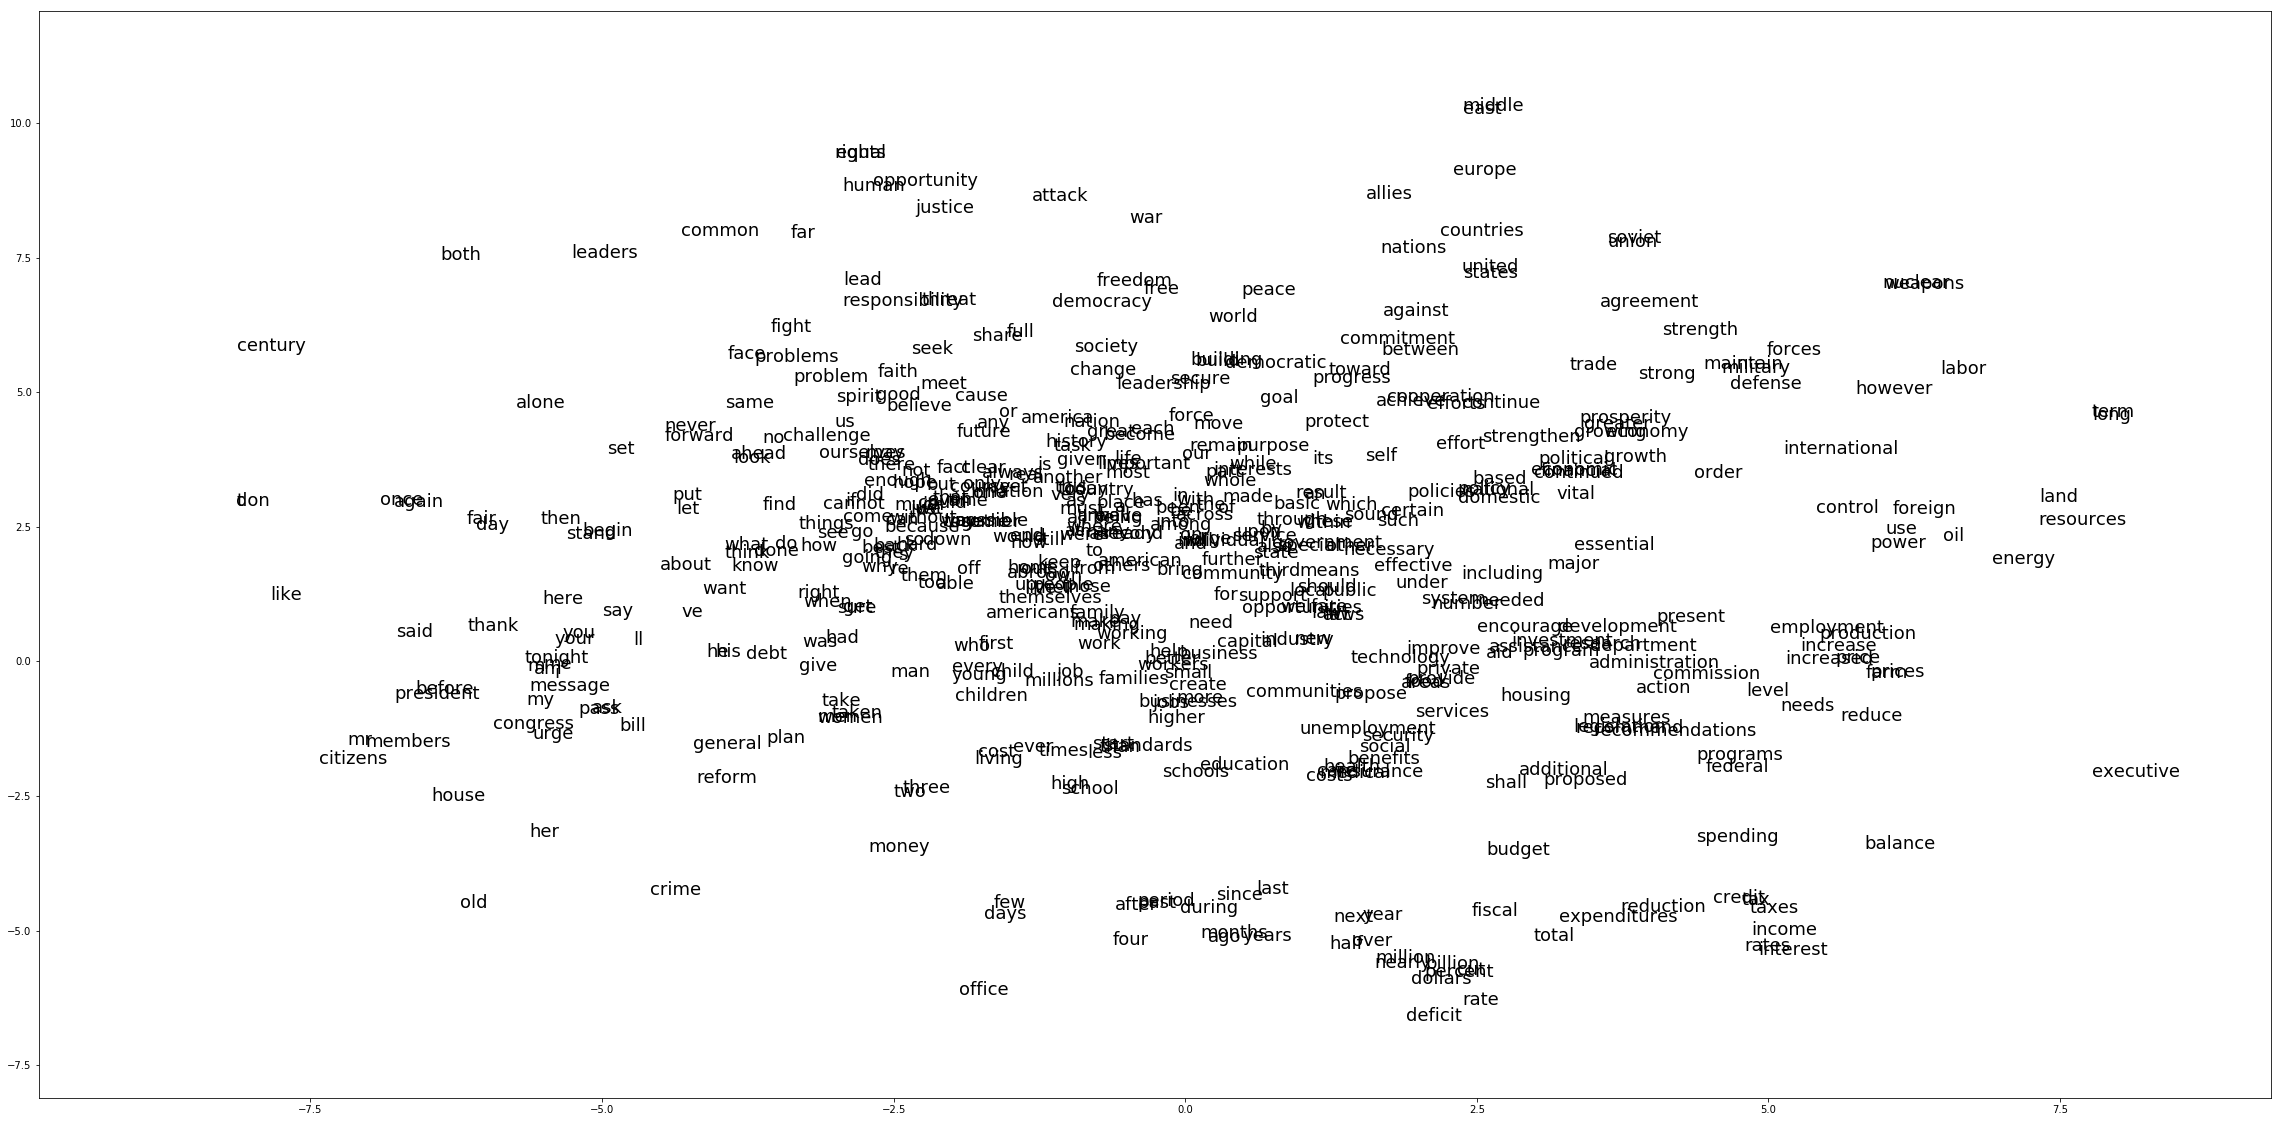

In [27]:
#import matplotlib
#matplotlib.use('Agg') # for pngs
import matplotlib.pyplot as plt

# plot our results
# make it quite big so we can see everything
fig, ax = plt.subplots(figsize=(40, 20))

# extract x and y values separately
xs = points[:,0]
ys = points[:,1]

# plot the points
# we don't actually care about the point markers,
# just want to automatically set the bounds of the plot
ax.scatter(xs, ys, alpha=0)
#for i, point in enumerate(points):
for i in range(1,500): 
    actstr=reverse_word_index.get(i)
    if (actstr.isalpha()==True):
               ax.annotate(actstr,(xs[i], ys[i]),fontsize=18)
    else:
        pass
plt.show()

![tSNE of State of the Union word embeddings](../assets/tsne.png)

This looks pretty good! It could certainly be improved upon, with more data or more training, but it's a great start.

## Further Reading

- [Deep Learning, NLP, and Representations](http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/). Chris Olah.
- [On Word Embeddings](http://sebastianruder.com/word-embeddings-1/). Sebastian Ruder.
- Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). [Efficient estimation of word representations in vector space](http://arxiv.org/pdf/1301.3781.pdf). arXiv preprint arXiv:1301.3781.
- Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). [Distributed representations of words and phrases and their compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). In Advances in neural information processing systems (pp. 3111-3119).